### Clustering ###

In [27]:
from matplotlib.image import imread
image = imread(r"C:\Users\royha\Documents\Uni\SimData\cats-vs-dogs\clustering test\21.jpg")
image.shape

(404, 360)

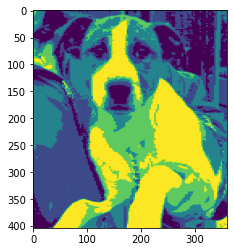

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=5).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

imgplot = plt.imshow(segmented_img)

In [29]:
segmented_img

array([[170.52741722, 170.96781457, 170.08      , ...,  81.16472377,
         80.80351411,  81.21557696],
       [170.52741722, 170.96781457, 170.08      , ...,  81.16472377,
         80.80351411,  81.21557696],
       [170.52741722, 170.96781457, 170.08      , ...,  81.16472377,
         80.80351411,  81.21557696],
       ...,
       [ 43.7063192 ,  42.85295706,  43.85363219, ..., 211.86857143,
        212.30322581, 211.87410138],
       [ 43.7063192 ,  42.85295706,  43.85363219, ..., 211.86857143,
        212.30322581, 211.87410138],
       [ 43.7063192 ,  42.85295706,  43.85363219, ..., 211.86857143,
        212.30322581, 211.87410138]])

### Running the First Model ###

In [30]:
from sklearn.model_selection import train_test_split
import os, cv2
import numpy as np

# dog = 0, cat = 1
def LoadAnimals(directory, clustering=0):
    x = []
    y = []

    for filename in os.listdir(directory):
        if 'dog' in filename:
            animal_class = 0
        else: # cat
            animal_class = 1

        f = os.path.join(directory, filename)
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)

        if clustering != 0:
            reshaped_image = image.reshape(-1, 3)
            kmeans = KMeans(n_clusters=clustering).fit(reshaped_image)
            segmented_img = kmeans.cluster_centers_[kmeans.labels_]
            segmented_img = segmented_img.reshape(image.shape)
            image = segmented_img

        x.append(np.concatenate(image)) # sklearn doesn't like 3d arrays (x_train is an array of 2d arrays -> 3d array). Transforms 3d array to 2d.
        y.append(animal_class)

    return x, y

In [33]:
x, y = LoadAnimals(r"C:\Users\royha\Documents\Uni\SimData\cats-vs-dogs\clusters", clustering=0)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(x_train, y_train)
forest.score(x_test, y_test)

0.647

In [22]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg.score(x_test, y_test)

c:\Users\royha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.543

In [24]:
from sklearn.dummy import DummyClassifier

dum = DummyClassifier(strategy="stratified")
dum.fit(x_train, y_train)
dum.score(x_test, y_test)

0.508